# AAO GALAH RESEARCH JAN-APR 2016

### Missy McIntosh, Gayandhi de Silva, Jeffrey Simpson
http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc111+ad2k+ad2000.coo

#### Check if there are any known open clusters in GALAH
#### This is a very slow python script....

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK4
import time
from tqdm import *
import pandas as pd
import codecs
import numpy as np
from lxml import html
from lxml import etree
import requests
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK4
import csv
from numpy import genfromtxt

In [147]:
def coordconvert(ra, dec):
    c = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))
    newra = c.ra.degree
    newdec = c.dec.degree
    return(newra, newdec)

def getwebda(name):
    try:
        # fetch coordinates 
        linkpt1 = "http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?"
        linkpt2 = "+ad2k+ad2000.coo"
        link = linkpt1+name+linkpt2
        page = requests.get(link)
    except:
        print("Couldn't find coordinate link for", name)
        print(link)
    try:
        tree = html.fromstring(page.content)
        text = str(etree.tostring(tree))
        temp = text.split(r'\n\n ')
        temp = temp[-1]
        temp = temp.split(r'\n')
        temp = temp[:-2]
        temp = [x.split(r'  ') for x in temp]
        temp = [list(filter(None, x)) for x in temp]
        subsetcid =np.asarray([x[0] for x in temp])
        coords = [coordconvert(coord[2], coord[3]) for coord in temp]
        subsetra = np.asarray([coord[0] for coord in coords])
        subsetdec = np.asarray([coord[1] for coord in coords])
    except:
        print("error with parsing coords html")
        print(link)
        subsetcid = None
        subsetra = None
        subsetdec = None
        return(None, None, None, None, None)
        
    # fetch magnitudes 
    try:
        linkpt1 = "http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?"
        linkpt2 = "+ubvpg+ubv.pgo"
        link = linkpt1+name+linkpt2
        page = requests.get(link)
    except:
        print("Couldn't find magnitude link for", name)
        print(link)
    try:
        tree = html.fromstring(page.content)
        text = str(etree.tostring(tree))
        temp = text.split(r'\n\n ')
        temp = temp[-1]
        temp = temp.split(r'\n')
        temp = temp[:-2]
        temp = [x.split(r'  ') for x in temp]
        temp = [list(filter(None, x)) for x in temp]
        subsetmid =np.asarray([x[0] for x in temp])
        subsetvmag = np.asarray([x[2] for x in temp])
    except:
        print("error with parsing mags html")
        print(link)
        subsetmid = None
        subsetvmag = None
        return(None, None, None, None, None)
        
    # we only want data where both RA/DEC and Vmag are available
    both = list(set(subsetcid).intersection(subsetmid))
    
    index = np.in1d(subsetcid, both).nonzero()
    bothra = subsetra[index]
    bothdec = subsetdec[index]
    bothcid = subsetcid[index]

    index = np.in1d(subsetmid, both).nonzero()
    bothvmag = subsetvmag[index]
    bothmid = subsetmid[index]
        
    return(bothcid, bothra, bothdec, bothmid, bothvmag)
     
   


def pbsearch(sorted_data, subset, tolerance):
    # a function of the declination 
    tol = tolerance
    searched_arr = []
    matched_arr = []
    
    for i in tqdm(range(len(subset))):
        a = subset[i]
        tol = abs(a[0]*np.cos(a[1]))
        print(tol)
        ra = sorted_data[:]
        n = list.__len__(ra)
        for element in np.arange(0,n):
            index = int(n/2)
            entry = ra[index]
            
            if a[0] - tol > entry[0]:
                print("a[0] - tol > entry[0]", a[0] - tol > entry[0])
                ra = ra[index:]
            elif a[0] + tol < entry[0]:
                print("a[0] + tol < entry[0]",a[0] + tol < entry[0])
                ra = ra[:(index)]
            else:
                # ra match, check dec
                if (np.absolute(a[1] - entry[1]) <= tol):
                    matched_arr.append(entry)
                    searched_arr.append(a)
                    
                ra.pop(index)
                if not ra:
                    break
                
            try:
                n = list.__len__(ra)
            except:
                break
            
    

    print("searched for a subset of ", len(subset), "RAs against 2mass list of", len(sorted_data), "RAs")
    print("RA matches: ", len(matched_arr), "with a tolerance of ", tolerance)
    return(searched_arr,matched_arr)

# if distance to line is less than 3 * length of 1 sigma from line, add to array
def wisigma(a, b, sigma):
    a = np.array(a)
    b = np.array(b)
    dist = np.linalg.norm(a-b)
    if dist < 3*sigma:
        return(True)
    else:
        return(False)

In [33]:
%%prun 
# Read in Jeffrey's 2Mass input database Name, RA, and DEC information
# note this data is presorted by RA

df = pd.read_csv('jsortedgal.csv', delimiter=',',index_col=False, header=0, dtype=float)
df.columns = ["ID", "VMag", "RA", "DEC"]

#df.sort_values("RA")
#all(l[i] <= l[i+1] for i in np.arange(len(l)-1))
# there's some weird sorting problems. A few are multiplied by 10^-4 for some reason
l = (df["RA"])
problems = []
for i in np.arange(len(l)-1):
    if (l[i] <= l[i+1]):
        continue
    else:
        problems.append(i+1)
print(len(problems), "weird sorts")
for problem in problems:
    df["RA"][problem] = df["RA"][problem]*10000



10 weird sorts
 

In [36]:
print(len(df))
twomass_ident = np.asarray(df["ID"])
twomass_vmag = np.asarray(df["VMag"])
twomass_ra = np.asarray(df["RA"])
twomass_dec = np.asarray(df["DEC"])

twomasszip = list(zip(twomass_ra, twomass_dec, twomass_vmag, twomass_ident))

9073309
[(0.0010089999999999999, -57.713554000000002, 13.429, 1093660.0), (0.0010449999999999999, -75.687950000000001, 12.412000000000001, 179614.0), (0.001108, -34.697871999999997, 11.446, 2969783.0), (0.001129, -9.856497000000001, 12.242000000000001, 4979866.0), (0.00116, 3.0209069999999998, 12.909000000000001, 8247442.0)]


In [35]:
# Read in WEBDA

#I got this html from querying webda for all clusters with J2000 coordinate data available

# connect to webda database
# grab each cluster name
## search this page: http://www.univie.ac.at/webda/cgi-bin/seldb.cgi?
## for links like http://www.univie.ac.at/webda/cgi-bin/ocl_page.cgi?dirname=wes02
## and grab the string after dirname=  
# these are the clusters that have coordinate data
# do the same for UBV data, and take only the names of clusters that have both
#http://www.univie.ac.at/webda/webda_selection.html
#I queried for UBV photoelectric observations
#and Equatorial coordinates J2000 and saved the resulting table data to acquire the names of the clusters for which this data was available


f = codecs.open("webdacoords.html", "r", "utf-8")
page = f.read()
split = page.split("dirname=")
coordnames = [split[x].split('"')[0] for x in np.arange(len(split))]
coordnames = coordnames[1:]
f = codecs.open("webdamag.html", "r", "utf-8")
page = f.read()
split = page.split("dirname=")
magnames = [split[x].split('"')[0] for x in np.arange(len(split))]
magnames = magnames[1:]

wnindices = [i for (i, x) in enumerate(magnames) if x in coordnames]
webnames = [magnames[i] for i in wnindices]
print(len(webnames))

cnindices = [i for (i, x) in enumerate(magnames) if x in webnames]
isplit = [split[i] for i in cnindices]
temp = [isplit[x].split(";")[1] for x in np.arange(len(isplit))][1:]
clusternames = [temp[x].split("&")[0] for x in np.arange(len(temp))]

# read in dias results
data = genfromtxt('dias_wtol0.005556_matched125.csv', delimiter=',', dtype=None)
data = data[0]
diasnames = [row.decode('UTF-8') for row in data]

fwnindices = [i for (i, x) in enumerate(clusternames) if x in diasnames]
print([list(clusternames)[i] for i in fwnindices])
filteredwebnames = [(webnames)[i] for i in fwnindices]
print(filteredwebnames)
print(len(filteredwebnames))

# it looks like the first elements don't match
names = filteredwebnames[1:]

#i = 1
#name = names[i]
#subsetid, subsetra, subsetdec = getwebda(name)

428
['Collinder 121', 'Collinder 132', 'IC 4651', 'IC 4756', 'NGC 2112', 'NGC 2186', 'NGC 2204', 'NGC 2354', 'NGC 2477', 'NGC 2516', 'NGC 2682', 'NGC 3680', 'NGC 3960', 'NGC 6087', 'NGC 6124', 'NGC 6716', 'Ruprecht 20', 'Tombaugh 1']
['cr097', 'cr132', 'ic4651', 'ic4756', 'ngc2112', 'ngc2186', 'ngc2204', 'ngc2354', 'ngc2477', 'ngc2516', 'ngc2682', 'ngc3680', 'ngc3960', 'ngc6087', 'ngc6124', 'ngc6716', 'ru020', 'to01']
18


In [ ]:
%%prun
tol = 0.005556
coorddeviation = []

for y in tqdm(range(len(names))):

    name = names[y]

    subsetid, subsetra, subsetdec, subsetmid, subsetvmag = getwebda(name)
    if (subsetid) is None:
        print("skipping", name)
        continue
    print(name)
    subsetzip = list(zip(subsetra, subsetdec, subsetvmag, subsetmid,subsetid))
    print("data retrived, starting pbsearch")
    searched_ra, matched_ra = pbsearch(twomasszip, subsetzip, tol)

    

    n = list.__len__(matched_ra)
    if n > 0:
        
        
        # magnitude filter    
        x = [float(x[2]) for x in searched_ra]
        y = [float(y[2]) for y in matched_ra]

        # mostly from http://stackoverflow.com/questions/28505008/numpy-polyfit-how-to-get-1-sigma-uncertainty-around-the-estimated-curve

        n = 1# degree of polynomial
        s=3 # number of sigma
        p, C_p = np.polyfit(x, y, n, cov=True)  # C_z is estimated covariance matrix

        # Do the interpolation for plotting:
        t = np.linspace(min(x), max(x), len(x))
        # Matrix with rows 1, t, t**2, ...:
        TT = np.vstack([t**(n-i) for i in range(n+1)]).T
        yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
        C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
        sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

        # Do the plotting:
        fg, ax = plt.subplots(1, 1)
        ax.set_title("Fit with $\pm{}\sigma$-interval".format(s))
        ax.fill_between(t, yi+(s*sig_yi), yi-(s*sig_yi), alpha=.25)
        ax.plot(t, yi,'-r')
        plt.scatter(x,y, s=30, alpha=0.15, marker='o')
        #ax.plot(x, y, 'ro')
        ax.axis('tight')

        fg.canvas.draw()
        plt.show()

        a = list(zip(x,y))
        b = list(zip(t, yi))

        bools = []
        for i in np.arange(len(x)):
            bol = wisigma(a[i], b[i], s*sig_yi[i])
            bools.append(bol)


        # what's the average distance away from the line of best fit from these 3 sigma guys?
        print(sum(bools))
        indices = np.nonzero(bools)[0]
        matchedfmag = [matched_ra[index] for index in indices]
        a = [np.array([x[0], x[1]]) for x in matchedfmag]
        searchedfmag = [searched_ra[index] for index in indices]
        b = [np.array([x[0], x[1]]) for x in searchedfmag]
        dists = [np.linalg.norm(a[i]-b[i]) for i in np.arange(len(a))]
        coorddeviation.append(np.std(dists))

        
        print(n, "matches for", name, "for tolerance", tol)
        filename = name+"_wtol"+str(tol)+"_matched"+str(n)+'.csv'
        header = ["webdacoordid", "webdaras", "webdadecs", "webdamagid", "webdavmags", "galahids", "twomassras", "twomassdecs", "twomassvmags"]
        with open(filename, 'w', newline='') as fp:
            a = csv.writer(fp, delimiter=',')
            a.writerow(header)
            for i in np.arange(n):
                data = [searchedfmag[i][4], searchedfmag[i][0], searchedfmag[i][1], searchedfmag[i][3], searchedfmag[i][2], matchedfmag[i][3], matchedfmag[i][0], matchedfmag[i][1], matchedfmag[i][2]]
                a.writerow(data)
    else:
        print("No matches for", name, "for tolerance", tol)


  6%|▌         | 1/17 [00:01<00:26,  1.66s/it]

In [53]:

n = list.__len__(matched_ra)
if n > 0:
    print(n, "matches for", name, "for tolerance", tol)
    filename = name+"_wtol"+str(tol)+"_matched"+str(n)+'.csv'
    header = ["webdacoordid", "webdaras", "webdadecs", "webdamagid", "webdavmags", "galahids", "twomassras", "twomassdecs", "twomassvmags"]
    with open(filename, 'w', newline='') as fp:
        a = csv.writer(fp, delimiter=',')
        a.writerow(header)
        for i in np.arange(n):
            data = [searched_ra[i][4], searched_ra[i][0], searched_ra[i][1], searched_ra[i][3], searched_ra[i][2], matched_ra[i][3], matched_ra[i][0], matched_ra[i][1], matched_ra[i][2]]
            a.writerow(data)
else:
    print("No matches for", name, "for tolerance", tol)


(279.31554583333332, 5.3178861111111111, ' 9.10', ' 0048', ' 0040')
(279.31557299999997, 5.3178739999999998, 9.3239999999999998, 6061249.0)
114 matches for ic4756 for tolerance 0.005556


In [ ]:
print("starting dec indexing")

searcheddec = [subsetdec[subsetra == ra] for ra in searched_ra] 
matcheddec = [twomass_dec[twomass_ra == ra] for ra in matched_ra]

print("finished dec indexing, comparing decs")

bools = []
for i in np.arange(len(matcheddec)):
    bol = checkdec(matcheddec[i],searcheddec[i], tol)
    bools.append(bol)

print("writing file")
n= np.sum(bools)
if n > 0:
    print(n, "matches for", name, "for tolerance", tol)
    fullmatchindex = np.where(bools)[0]


    galahids = [twomass_ident[int(index)] for index in fullmatchindex]
    twomassvmags = [twomass_vmag[int(index)] for index in fullmatchindex]
    twomassras = [twomass_ra[int(index)] for index in fullmatchindex]
    twomassdecs =[twomass_dec[int(index)] for index in fullmatchindex]

    subindices = [searcheddec_index[int(index)] for index in fullmatchindex]
    subsetids = [subsetid[index] for index in subindices]
    subsetras = [subsetra[index] for index in subindices]
    subsetdecs = [subsetdec[index] for index in subindices]

    filename = name+"_wtol"+str(tol)+"_matched"+str(n)+'.csv'
    with open(filename, 'w', newline='') as fp:
        a = csv.writer(fp, delimiter=',')
        data = [subsetids, webdaras, webdadecs, webdavmags, galahids, twomassras, twomassdecs, twomassvmags]
        a.writerows(data)
else:
    print("No matches for", name, "for tolerance", tol)



In [97]:
print(searched_ra[0])
print(matched_ra[0])
x = [float(x[2]) for x in searched_ra]
y = [float(y[2]) for y in matched_ra]
print(len(x))

(279.13845833333329, 5.2118888888888888, ' 8.86', ' 0028', ' 0028')
(279.13844, 5.2119470000000003, 8.9160000000000004, 6053126.0)
114


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


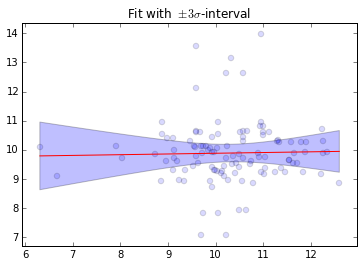

76
1.20530506444 +/- 0.755124048182


0.000177914523765 0.0027419147764


In [ ]:
# Read in DIAS 
# I didn't know an easy way to read in this file so this is very messy and hacked and slow and I apologize


dias_data = np.genfromtxt('dias.txt', delimiter='\t', names=None, dtype=None)
dias_data = dias_data[1:]

data = []
subsetid = []
subsetra = []
subsetdec = []
for line in dias_data:
 
    line = line.decode('UTF-8')

    line = (str(line).split("  "))

    line = np.array(list(filter(None, line)))
    subsetid.append(line[0])
    try:
        c = SkyCoord(line[1], line[2], unit=(u.hourangle, u.deg))
        subsetra.append(c.ra.degree)
        subsetdec.append(c.dec.degree)
    except:
        print("error: ", line)
    data.append(line)
    
# some problems with dec
subsetra = np.asarray(subsetra)
subsetdec = np.asarray(subsetdec)
name = "dias"



In [ ]:
# search each coord in file against 2 mass

# return subset RAs found within sorted data
# tolernece is 20 arc seconds
tol = 0.005556
searched_ra, matched_ra = pbsearch(twomass_ra, subsetra, tol)

In [ ]:
# retrieve the DEC and indicies of the found subset RAs
# check that the DEC values are w/i tolerence and return matched indices
# indices returned are for 2MASS

searcheddec = [subsetdec[subsetra == ra] for ra in searched_ra] 
matcheddec = [twomass_dec[twomass_ra == ra] for ra in matched_ra]


In [ ]:
bools = []
for i in np.arange(len(matcheddec)):
    bol = checkdec(matcheddec[i],searcheddec[i], tol)
    bools.append(bol)


# select info on the matched RA and DECs
n= np.sum(bools)
if n > 0:
    print(n, "matches for", name, "for tolerance", tol)
    fullmatchindex = np.where(bools)[0]
    galahids = [twomass_ident[int(index)] for index in fullmatchindex]
    #subsetids = [subsetid[searcheddec_index[index]] for index in fullmatchindex]
    subsetids = [searcheddec_index[index] for index in fullmatchindex]
    filename = name+"_wtol"+str(tol)+"_matched"+str(n)+'.csv'
    with open(filename, 'w', newline='') as fp:
        a = csv.writer(fp, delimiter=',')
        data = [subsetids, galahids]
        a.writerows(data)
else:
    print("No matches for", name, "for tolerance", tol)
   

In [27]:
name = names[1]

subsetid, subsetra, subsetdec, subsetmid, subsetvmag = getwebda(name)



error with parsing mags html
http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr132+ubvpg+ubv.pgo
error


In [24]:
print(subsetid)
#subsetmid =np.asarray([x[0] for x in temp])
#subsetvmag = np.asarray([x[2] for x in temp])

[' 0107' ' 0107' ' 0109' ' 0111' ' 0112' ' 0113' ' 0115' ' 0115' ' 0117'
 ' 0117' ' 0119' ' 0120' ' 0121' ' 0121' ' 0122' ' 0122' ' 0123' ' 0124'
 ' 0125' ' 0125' ' 0127' ' 0128' ' 0128' ' 0129' ' 0129' ' 0131' ' 0131'
 ' 0132' ' 0133' ' 0133' ' 0134' ' 0135' ' 0201' ' 0203' ' 0204' ' 0204'
 ' 0205' ' 0206' ' 0207' ' 0208' ' 0209' ' 0210' ' 0211' ' 0212' ' 0213'
 ' 0214' ' 0215' ' 0217' ' 0217' ' 0218' ' 0218' ' 0219' ' 0219' ' 0221'
 ' 0221' ' 0222' ' 0222' ' 0223' ' 0223' ' 0224' ' 0224' ' 0225' ' 0225'
 ' 0226' ' 0226' ' 0227' ' 0227' ' 0228' ' 0228' ' 0229' ' 0301' ' 0302'
 ' 0305' ' 0305' ' 0307' ' 0307' ' 0311' ' 0312' ' 0312' ' 0313' ' 0314'
 ' 0315' ' 0315' ' 0319' ' 0319' ' 0403' ' 0404' ' 0405' ' 0406' ' 0407'
 ' 0408' ' 0409' ' 0410' ' 0411' ' 0412' ' 0413' ' 0414' ' 0414' ' 0415'
 ' 0415' ' 0416' ' 0417' ' 0417' ' 0418' ' 0418' ' 0419' ' 0419' ' 0420'
 ' 0420' ' 0421' ' 0421']


In [ ]:
# back up for webda, download files individually
# Read in Webda observed Name, RA, and DEC information
'''

df = pd.read_csv('ad2000.coo', delimiter='\t',index_col=False, header=1)
df.columns = ["ID", "ref", "RA", "DEC"]


coords = [coordconvert(ra, dec) for ra in df["RA"] for dec in df["DEC"]]
subsetra = np.asarray([coord[0] for coord in coords])
subsetdec = np.asarray([coord[1] for coord in coords])
'''

# Read in Gayandhi's 2Mass input database Name, RA, and DEC information
# note this data is presorted by RA
'''

df = pd.read_csv('gsortedgal.csv', delimiter=',',index_col=False, header=0)
df.columns = ["ID", "RA", "DEC"]

# get rid of blank entries
print(len(df))
df = df.loc[(df != 0).any(1)]
print(len(df))
print(df.head())

# assign to np arrays
twomass_ident = np.asarray(df["ID"])
twomass_ra = np.asarray(df["RA"])
twomass_dec = np.asarray(df["DEC"])

'''

In [73]:
if (subsetid) is None:
    print("none")

none


In [68]:
print(subsetid)

[' 0028' ' 0028' ' 0030' ' 0031' ' 0031' ' 0036' ' 0036' ' 0038' ' 0038'
 ' 0039' ' 0039' ' 0040' ' 0040' ' 0041' ' 0041' ' 0043' ' 0043' ' 0045'
 ' 0047' ' 0047' ' 0048' ' 0048' ' 0049' ' 0049' ' 0050' ' 0050' ' 0052'
 ' 0052' ' 0054' ' 0056' ' 0056' ' 0058' ' 0058' ' 0059' ' 0059' ' 0061'
 ' 0061' ' 0062' ' 0062' ' 0063' ' 0063' ' 0066' ' 0066' ' 0067' ' 0067'
 ' 0068' ' 0068' ' 0069' ' 0069' ' 0070' ' 0070' ' 0071' ' 0071' ' 0072'
 ' 0072' ' 0073' ' 0073' ' 0074' ' 0074' ' 0075' ' 0075' ' 0078' ' 0078'
 ' 0079' ' 0079' ' 0080' ' 0080' ' 0081' ' 0081' ' 0082' ' 0082' ' 0083'
 ' 0083' ' 0084' ' 0084' ' 0087' ' 0088' ' 0091' ' 0091' ' 0092' ' 0092'
 ' 0093' ' 0093' ' 0094' ' 0094' ' 0097' ' 0097' ' 0098' ' 0098' ' 0100'
 ' 0100' ' 0101' ' 0101' ' 0102' ' 0102' ' 0103' ' 0103' ' 0104' ' 0104'
 ' 0105' ' 0106' ' 0109' ' 0109' ' 0110' ' 0110' ' 0114' ' 0115' ' 0116'
 ' 0116' ' 0117' ' 0117' ' 0118' ' 0118' ' 0120' ' 0123' ' 0123' ' 0125'
 ' 0125' ' 0127' ' 0127' ' 0128' ' 0128' ' 0130' ' 